In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Siksma, Casper (0902066)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I found that a wide neural network yielded the best performance in combination with an amsgrad optimizer, learning rate of 0.0001 and batch size of 128. The hyperparameters were optimized using a grid search. Softmax was used as activation function of the output layer as our data is onehot encoded and the sum of the outputs equals one. The model achieved good accuracy but might be overfitting a bit as the training loss keeps decreasing while the validation loss is flattening out. (length: 485)



Max val score: 84.79%


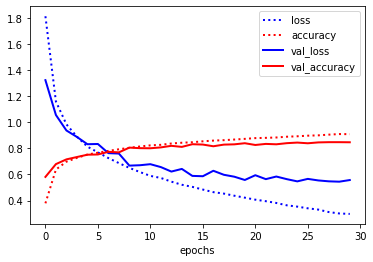

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 3000)              9219000   
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              4501500   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               750500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
Total params: 14,476,010
Trainable params: 14,476,010
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(3000, activation='relu'))
    model.add(layers.Dense(1500, activation='relu'))
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.0001, amsgrad=True),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



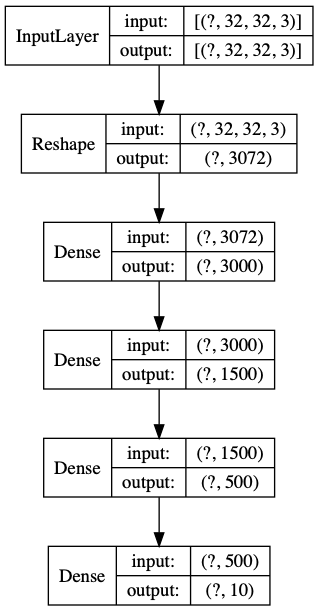

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

The same model was used as in 1.1 but with grayscale images resulting in input shape of (32,32,1) as the images now only have one color channel. The model performed slightly better achieving 0.859 accuracy, likely because of the reduced dimensionality, but might still be overfitting. The color of the image does not add any substantial new information but still increases the dimensionality a lot, which is also more computationally expensive. (length: 445)



Max val score: 85.91%


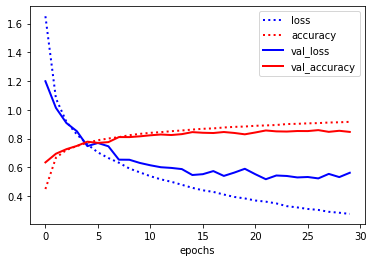

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3000)              3075000   
_________________________________________________________________
dense_5 (Dense)              (None, 1500)              4501500   
_________________________________________________________________
dense_6 (Dense)              (None, 500)               750500    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5010      
Total params: 8,332,010
Trainable params: 8,332,010
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(3000, activation='relu'))
    model.add(layers.Dense(1500, activation='relu'))
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.0001, amsgrad=True),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

Kernel regularizer L1 was ineffective and L2 resulted in much higher validation loss. Using dropout resulted in slightly better accuracy and lower validation loss, by allowing training for longer without overfitting. Dropout rates were compared using a grid search for rates between 0.1 and 0.5. The model could still be overfitting a bit as training loss is decreasing while validation loss is flattening out. (length: 411)



Max val score: 86.56%


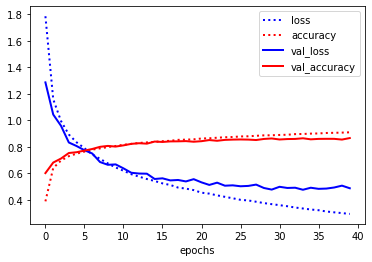

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(3000, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1500, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.0001, amsgrad=True),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

The best performance was achieved by leveraging a combination of batch normalization and pooling+dropout layers. A convolutional layer is followed by a batch normalization layer such that activations of the conv layer are standardized. This is then followed by a conv layer with the same number of output filters, which is then followed by a maxpooling layer which summarizes the most activated presence of a feature and a dropout layer. This is then repeated with double the number of output filters, up to 128. The hidden dense layer was downsized and the hyperparameters were mostly kept from part 1. The model achieves validation accuracy of 0.943 and does not seem to be overfitting up to epoch 25. As validation loss is still seemingly decreasing it might be underfitting a little bit. (length: 792)



Max val score: 94.33%


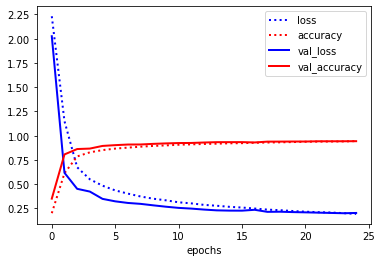

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)       

def build_model_2_1():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(32, 32, 1)))
    model.add(layers.Reshape((32, 32, 1)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu',  padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu',  padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    model.add(layer

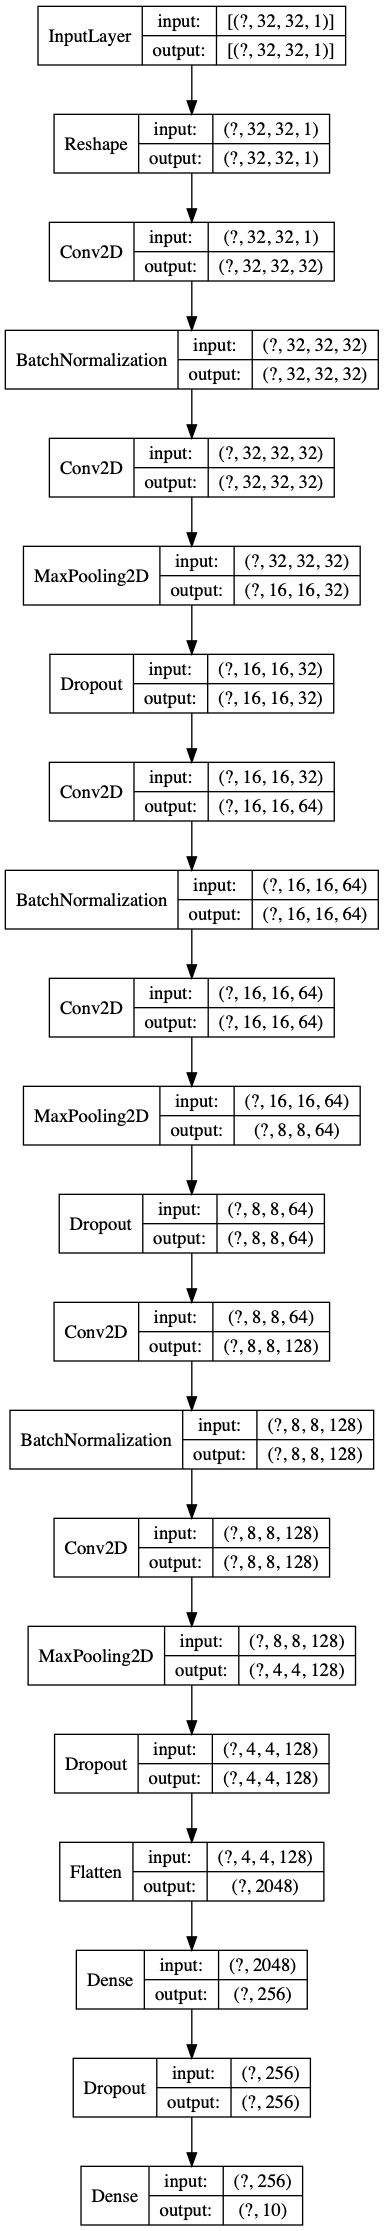

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

Large rotations of 45+ degrees, horizontal and vertical flips were not effective at all, likely because it does not actually represent the digit anymore. A little rotation, shear range, heigh shift and zoom proved effective. The amounts were optimized using a grid search. The model achieves validation accuracy of 0.961 and does not seem to be overfitting as training and validation loss are roughly the same. Also unlikely to be underfitting as validation loss does not seem to decrease anymore. (length: 498)



Max val score: 96.09%


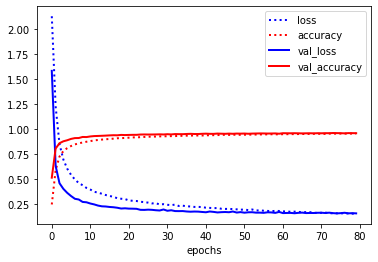


datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                             zoom_range=[0.85, 1.15],
                             height_shift_range=0.1,
                             shear_range=0.1)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

The model achieved a test accuracy of 0.9612. From the confusion matrix we can see that more similar numbers are more often confused than dissimilar numbers. Our model struggles especially with the number 3, which is most often confused with 5 or 1. When plotting the misclassifications, they are usually very low quality images with bad angles and difficult fonts where the stylized 3 has features usually attributed to some other digit. Some images would not even be intelligible by humans. (length: 493)

Test score: 0.96%


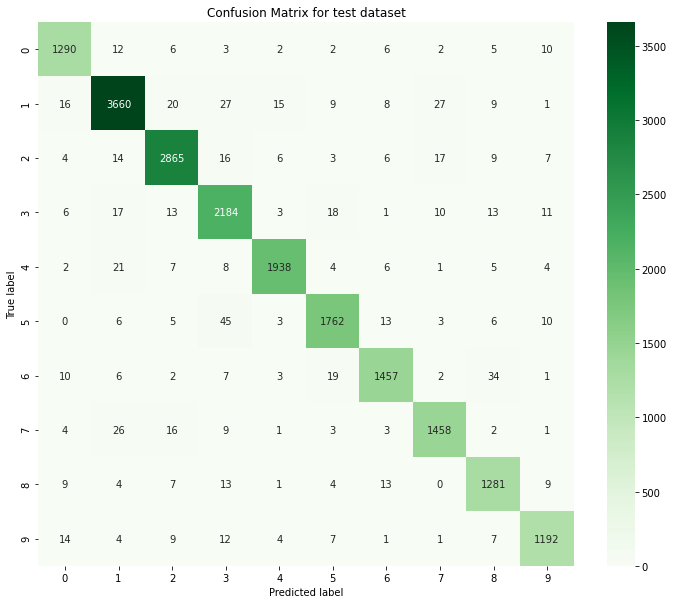

[8 2 1 ... 9 1 6]
[8 2 1 ... 9 1 6]


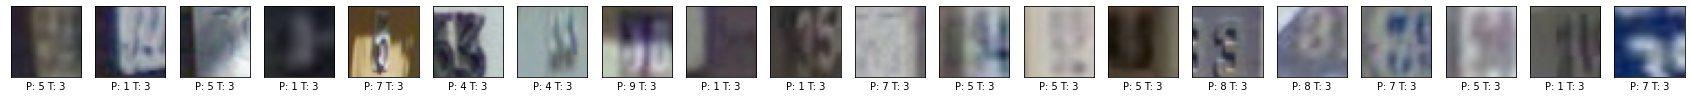

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

In each plot we see how the image reacts to different filters, the image does not react to some filters at all, while reacting strongly to others as can be seen in first convolutional layer output. Some filters have a more vertical response while others have a more horizontal one, this can be seen especially well in the second and third convolutional layer outputs. As we get into deeper layers, more higher level features are learned by our model and it is hard to understand what is going on. (length: 497)



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)       

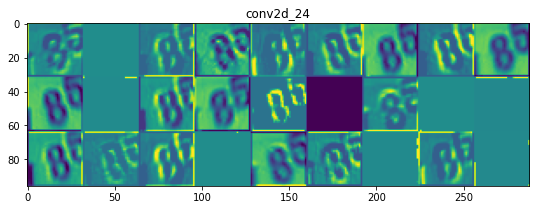

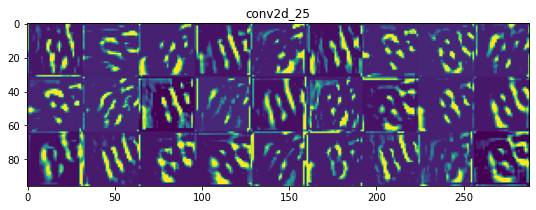

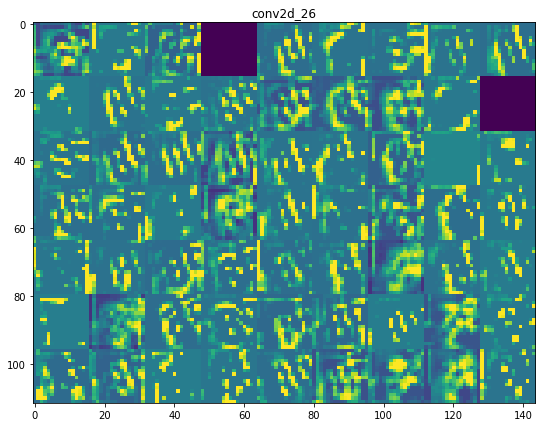

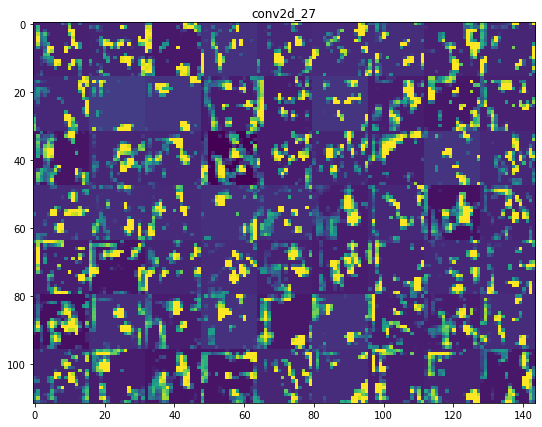

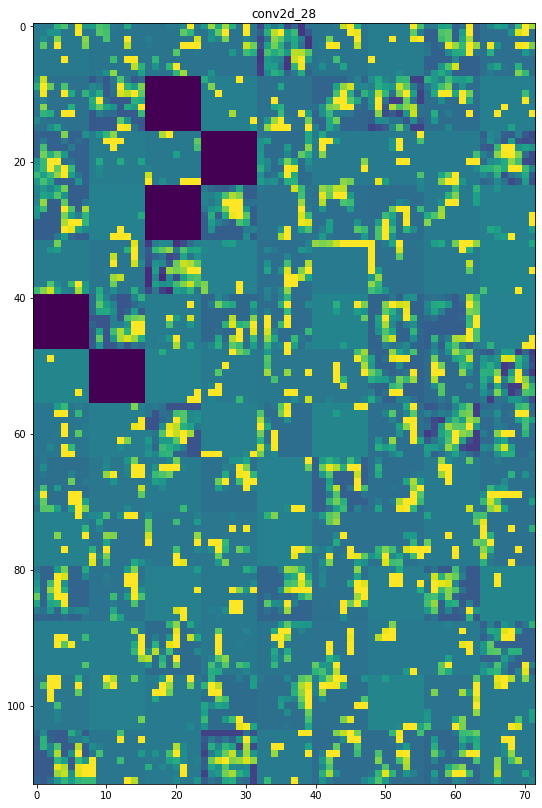

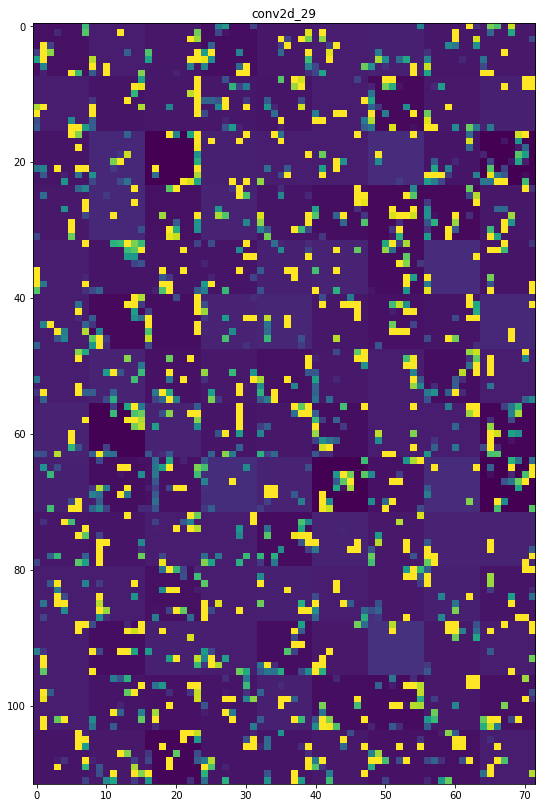

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)       

<Figure size 720x1080 with 0 Axes>

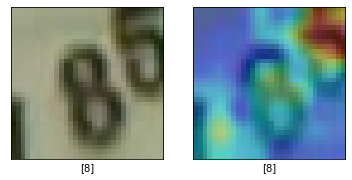

def plot_3_3():
  color_img = X_test[0]
  gray_img = rgb2gray([color_img])
  g = tensorflow.Graph()
  with g.as_default():
    model = load_model_from_file(base_dir, "model_2_2")
    
    model.summary()
    last_layer = model.get_layer('conv2d_29')
    y_test_pred = model.predict(gray_img)

    argmax = np.argmax(y_test_pred[0])
    output = model.output[:, argmax]

    # Disable eager execution
    tf.compat.v1.disable_eager_execution()
    grads = K.gradients(output, last_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([gray_img])

    for i in range(32):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)


    heatmap = cv2.resize(heatmap, (32, 32))
    heatmap = np.uint8(255 * heatmap)
    heat

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

Without unfreezing the last block of convolutional layers, the performance of the model was very bad and stuck below 60% validation accuracy. When unfreezing the last block of conv layers, results were much better with validation accuracy of 0.823. The model seems to be overfitting after 6 epochs when validation loss flattens out and training loss already decreasing rapidly. (length: 378)



Trainable layers:
input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
sequential_5 True


Max val score: 82.32%


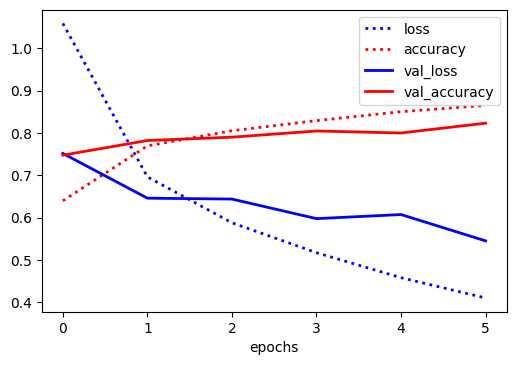

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

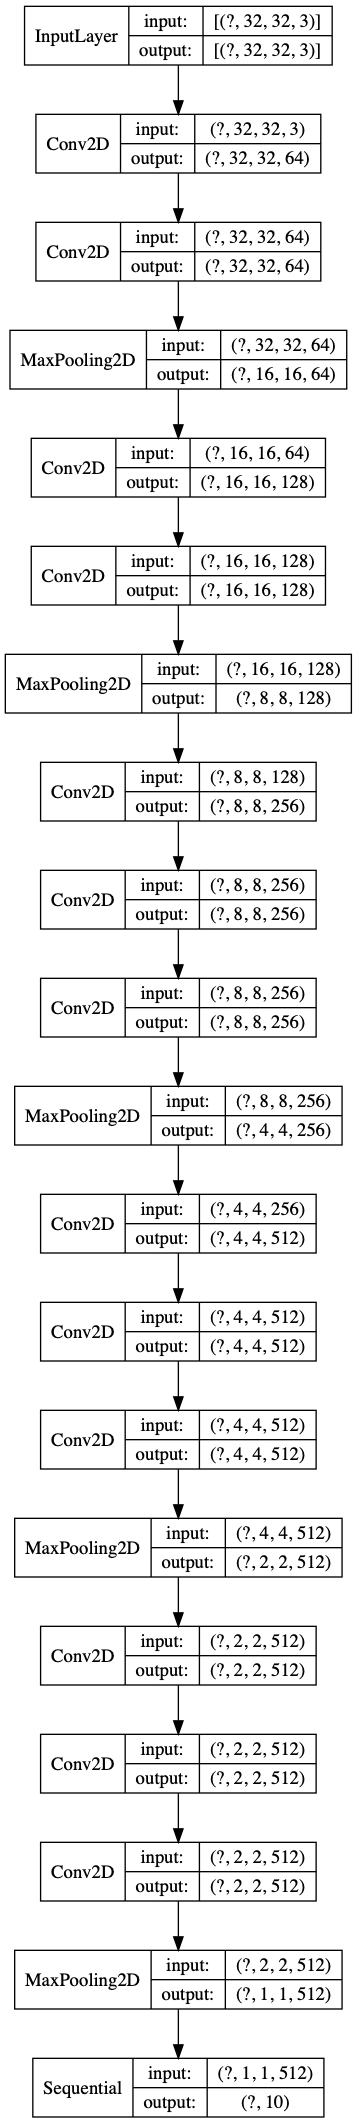

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

I constructed a new model from the model in 4.1 by taking the same layers without the last sequential layer and then adding a flatten layer. I ran the images through it, and saving the output tensor as pickle file. Random Forest was chosen, as linear regression would not converge and SVM took too long. The model achieved accuracy 0.833 which is better than the model in 4.1 with the dense layers, but still not close to my best model. (length: 437)

Pipeline(steps=[('classifier', RandomForestClassifier(random_state=1))])
def store_embeddings():
  model = load_model_from_file(base_dir, "model_4_1")

  new_model = models.Sequential()
  for layer in model.layers[:-1]:
    new_model.add(layer)
  new_model.add(layers.Flatten())
  new_model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.0001, amsgrad=True),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

  new_model.summary()

  X_train_embedded = new_model.predict(X_train)
  X_test_embedded

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 58.53 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
